# MOSAiC initial analysis

### Science goals
- Along the possible Mosaic tracks taken from historical data, we want to plot some basic ice state information <br>
- Show the LENS members (30) on each historical track (8) --> 240 iterations
- Show ensemble mean and 1 standard deviation
- Identify when variability arises and begin addressing causes the variability  (correlate arrays of means?)


### Requirements
- Requires netcdf files of the single variable interpolated to each of the ensemble members (30) along each track (8) for each day (365) <br>
- These files were made on burnt using extract_LENS_vars_mosaic_tracks-{ice,atm}.csh with a paired ncl script <br>
- On burnt see: /project/ppc/duvivier/mosaic/analysis/along_track <br>
- The files have been moved to Cheyenne and are minimal in size. See here:/glade/p/cgd/ppc/duvivier/mosaic_along_track_subset/
- Original single variable history files on cheyenne are available for all 30 members for the two year periods starting 1981-01, 2021-01, and 2051-01. These live here: /glade/p/cgd/ppc/duvivier/mosaic/


### Loading in packages and simple xarray manipulations

In [1]:
#minimal packages needed for this activity
import xarray as xr                          #for slick netCDF operations
import numpy as np                           #for standard numeric manipulation
import matplotlib.pyplot as plt              #standard plotting library based upon Matlab functions
import pickle                                #library for saving and loading Python variables into "pickle" format
from scipy import signal                     #loading frequency analysis part of scientific computing library "scipy"
from scipy import stats                      #loading stats part of scientific computing library "scipy"
from matplotlib.gridspec import GridSpec     #for multipanel plotting

%matplotlib inline

In [2]:
# Manual inputs
yy_st = 2021
ftype = 'ice'
path = '/glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/'+ftype+'/'

# get year strings
yy_ed = yy_st+1
yy_string = str(yy_st)+'0101-'+str(yy_ed)+'1231'

# indicies for labels - relevant to all these plots
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

years = ['2007','2008','2009','2010','2011','2012','2013','2014']

# Plots and Analysis

## Variable 1 - ice area

In [3]:
# set variable to read in
var1 = 'aice'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

Opening file /glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/ice/LENS_aice_mosaic_tracks_20210101-20221231.nc


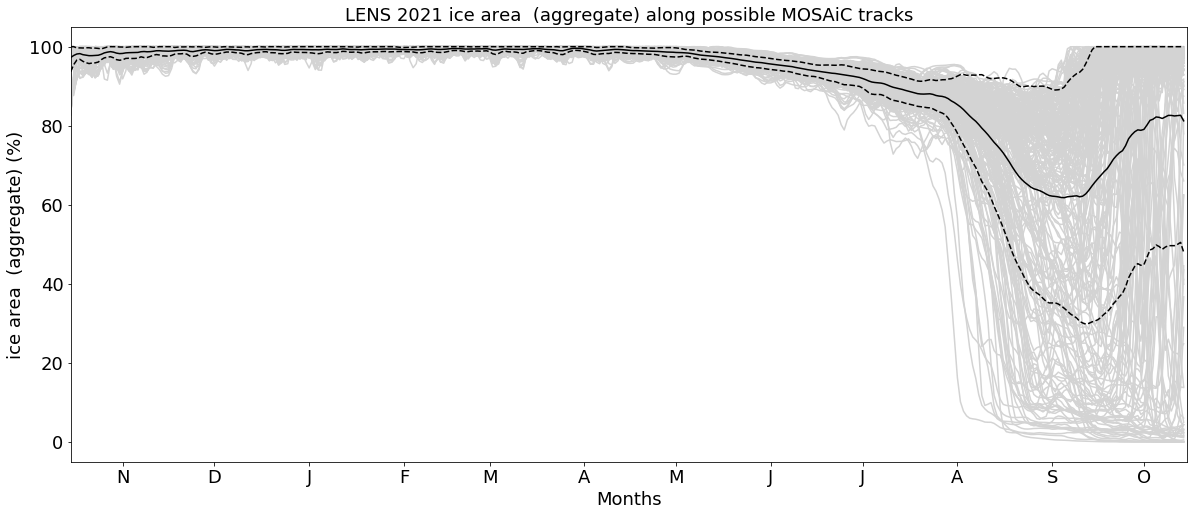

In [4]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name

# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])
bnd_high = var_mean + var_stdev
bnd_low = var_mean - var_stdev
# set limits of standard deviations to be physical (0-100)
bnd_high[bnd_high > 100.0] = 100.0  
bnd_low[bnd_high < 0.0] = 0.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),bnd_high,color='black',linestyle='dashed')
plt.plot(np.arange(365),bnd_low,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim([np.min(f1.data_tracks)-5,np.max(f1.data_tracks)+5])
plt.xlim(0,365);

What is of most interest here is the slow decline in summer (June-August) but that the slope dramatically shifts in August through the September minimum. We think the sharp drop offs in the concentration are from tracks that are "spit out" of the pack and through the ice edge in some of the simulations. I need to verify this by doing spatial plots. However, I need to identify some of those ensembles and years so I can find them. I also want to do something to prevent them from being included in the mean since they're no longer illustrative of the "pack".

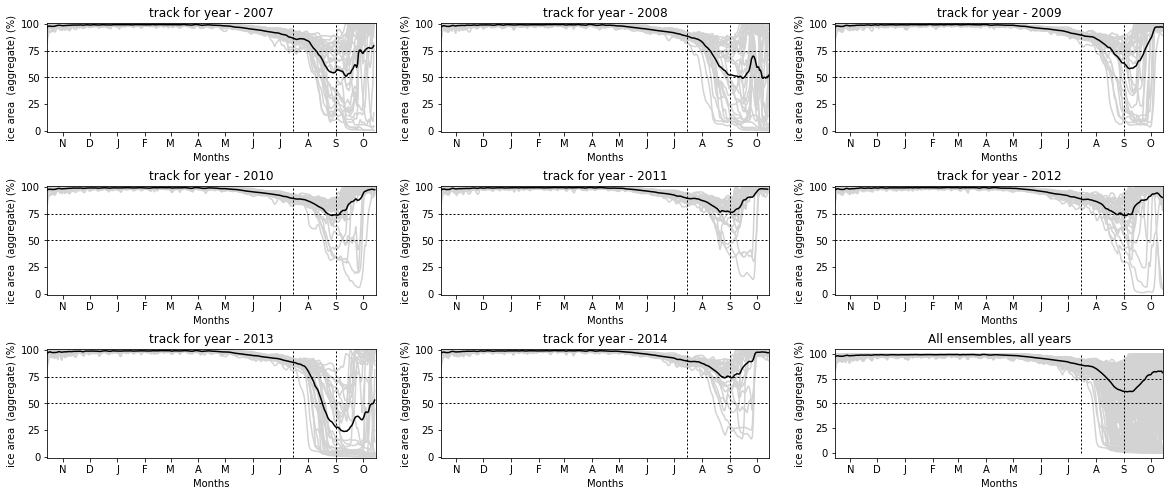

In [5]:
# plot the individual years of plots so we can see if there is systematic order to which drop off so much
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks by historical track year'

cols = 3
fig = plt.figure(figsize=(20,8))
gs = GridSpec(cols,cols,wspace=0.2,hspace=0.5)

# individual years
for t in np.arange(f1.year_track.size):
    row = (t // cols)
    col = t % cols
    f=plt.subplot(gs[row,col])
    for e in np.arange(f1.ensemble.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
    plt.plot(np.arange(365),f1.data_tracks.isel(year_track=t).mean(dim='ensemble'),color='black')
    plt.plot([273,273],[0,100],'k-',lw=1,dashes=[2,2])  # Jul.15 ref line
    plt.plot([321,321],[0,100],'k-',lw=1,dashes=[2,2])  # Sept.1 ref line\
    plt.plot([0,365],[75,75],'k-',lw=1,dashes=[2,2])    # 75% concentration ref line
    plt.plot([0,365],[50,50],'k-',lw=1,dashes=[2,2])    # 50% concentration ref line
    plt.title('track for year - '+years[t])
    plt.xlabel('Months')
    plt.ylabel(long_name+' ('+units+')')
    plt.xticks(label_inds,text)
    plt.ylim([np.min(f1.data_tracks)-1,np.max(f1.data_tracks)+1])
    plt.xlim(0,365);
    
#add all ensemble members at the end
f=plt.subplot(gs[row,col+1])
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot([273,273],[0,100],'k-',lw=1,dashes=[2,2])  # Jul.15 ref line
plt.plot([321,321],[0,100],'k-',lw=1,dashes=[2,2])  # Sept.1 ref line
plt.plot([0,365],[75,75],'k-',lw=1,dashes=[2,2])    # 75% concentration ref line
plt.plot([0,365],[50,50],'k-',lw=1,dashes=[2,2])    # 50% concentration ref line
plt.title('All ensembles, all years')
plt.xlabel('Months')
plt.ylabel(long_name+' ('+units+')')
plt.xticks(label_inds,text)
plt.ylim([np.min(f1.data_tracks)-5,np.max(f1.data_tracks)+5])
plt.xlim(0,365);

It looks like most the concentration drop off happens between July 1 and Sept.1 (not exclusively, but still...). Up till July 15 the concentration is above 75% nearly everywhere. The drop is usually to values <25%, which is a 50% concentration drop. So make an algorithm something like if (july15.value - sept1.value) .ge. 50, then set all values at dates after the 50% mark to NaN. 

Some years have tracks with a lot of drop off (e.g. 2008, 2013). Other years (e.g. 2011, 2014) have less drop off. Probably from track location further east/west to get near ice edge. 

Some years and ensembles with the drop off (to confirm with spatial plots):
for e in np.arange(f1.ensemble.size):
    print(f1.data_tracks.isel(ensemble=e,year_track=ENTER_HERE)[321]) # sept1 value
identified: 
year = 2008 --> ensembles 2, 7, 15, 26 (indexed from zero)
year = 2011 --> ensembles 2
year = 2013 --> ensembles 0, 2, (most)

In [6]:
# diff = f1.data_tracks.isel(days_from_start=273) - f1.data_tracks.isel(days_from_start=321)
# print(diff.values)

i = 0
j = 0
# replace any concentrations after the value drops below 50% with nans
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        inds = np.where(f1.data_tracks.isel(ensemble=e,year_track=t) < 50.0)
        if len(inds[0]) > 0:
            #print('replacing subsequent values with nans')
            firstindex = inds[0][0]
            #print(firstindex)
            filtered_conc = f1.data_tracks.isel(ensemble=e,year_track=t).values
            filtered_conc[firstindex:] = np.nan
            i = i+1
        else: 
            #print('nope')
            j = j+1

print('tracks that emerged from edge ',i)
print('tracks that stayed in pack ',j)
print('total tracks ',i+j)
            
#print (f1.data_tracks.isel(ensemble=1,year_track=3).values)

tracks that emerged from edge  99
tracks that stayed in pack  141
total tracks  240


In [7]:
# Make a mask I can use later with other variables 
mask_in_pack = f1.data_tracks.copy()
mask_in_pack = np.where(mask_in_pack.values > 0.0, 1.0, mask_in_pack.values);


/gpfs/u/apps/ch/opt/python/3.6.4/intel/17.0.1/pkg-library/20180129/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


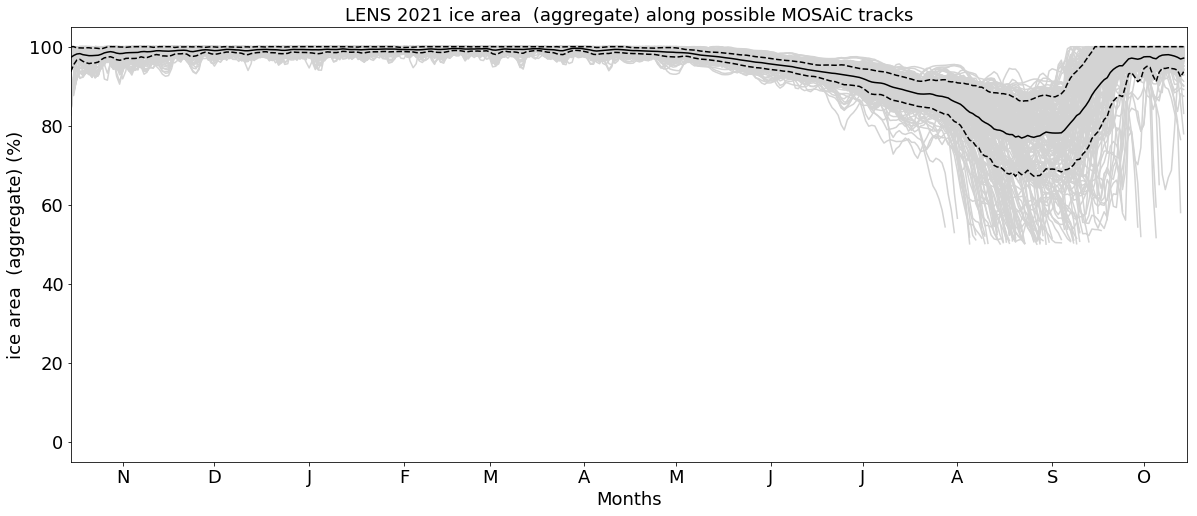

In [8]:
# replot the concentration

# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])
bnd_high = var_mean + var_stdev
bnd_low = var_mean - var_stdev
# set limits of standard deviations to be physical (0-100)
bnd_high[bnd_high > 100.0] = 100.0  
bnd_low[bnd_high < 0.0] = 0.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),bnd_high,color='black',linestyle='dashed')
plt.plot(np.arange(365),bnd_low,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim([-5,105])
plt.xlim(0,365);

Okay! This is interesting. The mean has shifted quite a bit once we remove the tracks that emerge from the ice edge.
We should filter by this for subsequent analysis because once a track emerges from pack, any information about it skews the mean and other information. Other things to analyze:
- Timing of first and last "ejection" from the pack, using the mask_in_pack array and the dates. Find for each year. Also ID which ensemble memebr it occurs for

In [ ]:
I think everything after this is irrelevant at the moment...

## Variable 2 - ice thickness

In [ ]:
# manual changes
var1 = 'hi'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name

# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])
bnd_high = var_mean + var_stdev
bnd_low = var_mean - var_stdev
# set limits of standard deviations to be physical (0-100)
bnd_low[bnd_high < 0.0] = 0.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),bnd_high,color='black',linestyle='dashed')
plt.plot(np.arange(365),bnd_low,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim([np.min(f1.data_tracks)-0.5,np.max(f1.data_tracks)+0.5])
plt.xlim(0,365);

In [ ]:
# look at mean thickness at start and end
diff = var_mean.values[364] - var_mean.values[0]
print('final minus original mean thickness: ', diff)
print('maximum mean thickness: ',np.amax(var_mean))

The ice starts with a mean around 1m with a stdev of 0.5m. One ensemble has consistently thicker ice (2m) throughout (top 8 lines for the 8 tracks). Growth occurs until about June, then decreases. There are thicknesses up to 3 m or more in some ensembles, though the mean has a maximum of ~2m. Want to understand growth through the winter too (mass budget). 

## Variable 3 - Snow fraction

In [ ]:
# manual changes
var1 = 'fs'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 4 - Snow thickness

In [ ]:
# manual changes
var1 = 'hs'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
#plt.ylim(0,101)
plt.xlim(0,365);

In [ ]:
f1.data_tracks.isel(ensemble=0,year_track=0).values

## Variable 5 - FYarea

In [ ]:
# manual changes
var1 = 'FYarea'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 6 - melt onset

In [ ]:
# manual changes
var1 = 'mlt_onset'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 7 - melt pond area

In [ ]:
# manual changes
var1 = 'apond'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

In [ ]:
# other order 1 variables. Also look by category (aicen001-005 and apond001-005). Also look into atmosphere variables (wind speed, wind dir, IWP, LWP, etc.)